# Title: A Text Document Clustering Method Based on Weighted BERT Model* 
# * Paper modified to: "A Text Document Clustering Method Based on BERT-TFIDF Model"

#### Raad Al-Husban

####  Emails: Ralhusban@gmail.com / Ralhusban@ryerson.ca

# Introduction:

#### Problem Description:

Text clustering is an important part of data mining and has a wide range of applications. Text clustering is a task of partitioning a collection of documents into meaningful groups. Documents that belong to a single cluster are supposed to be much more similar to each other compared to documents in other clusters.
#### Context of the Problem:

Clustering a large collection of documents is a complex process that usually can't be solved by simple clustering algorithms. Such algorithms require the input to be fixed-length feature vectors, therefore coming up with a way to represent these vectors is critical. 

#### Limitation About other Approaches:

There are many approaches to represent word vectors such as Vector Space Model (VSM) such as Term Frequency - Inverse Document Frequency (TF-IDF) embeddings, Word2Vec, GloVE, and others. Such approaches has a major weakness; they discard the ordering of the words and fail to capture semantic relation between the words. This could lead to problems, parituclarely when similar words my mean different things when their order and context changes. 

#### Solution:

The novel proposed method suggests from pre-trained Bidirectional Encoder Representations from Transformers (BERT) that is trained on a large amount of plain text (English Wikipedia and Book corpus) to generate contexualized text embeddings. These embeddings are merged with TF-IDF embeddings and then passed into a clustering algorithm . Such approach outperforms traditional text clustering approaches as shown in the implementation below

# Background

Explain the related work using the following table

| Reference |Explanation |  Dataset/Input |Weakness
| --- | --- | --- | --- |
| Shi et al. [4] | Self-supervised text clustering based on BERT with Data Augment| 20 Newsgroup | 62.2% Accuracy (Best supervised classification achieved 71.1%)
| Huang et al. [3] | Text Clustering using a fine-tuned and modified BERT with Clustering loss prior to passing into K-Means | TREC, YELP, & DBpedia | 39.91%, 33.4%, 66.99% accuracy respectively
| Zihua Dai et al. [2] | Clustering using BERT-then Self-Supervised model - BERT| Baidu Q&A Data | 83.4% Accuracy and 65.3% NMI
| Li et al. [1] | They clustered texted using a weighed pre-trained BERT model| Reuters-21578 | F1-Score remains a modest 25% on complex data with 15 topics. Future research on better text feature weighing schemes will be done


The last row in this table should be about the method discussed in this paper (If you can't find the weakenss of this method then write about the future improvement, see the future work section of the paper)

# Methodology

Provide details of the method that you are implementing in the next section with figure(s).  Your methodology will be just one method discussed in one of the paper of your choice; it can be a merger or a simplified version of the papers. To avoid any confusion, do not present multiple methods, just one unified method as you will implement in the next section.

For figures you can use this tag:

![Alternate text ](Figure.png "Title of the figure, location is simply the directory of the notebook")

# Implementation

In this section, you will provide the code and its explanation. You may have to create more cells after this. (To keep the Notebook clean, do not display debugging output or thousands of print statements from hundreds of epochs. Make sure it is readable for others by reviewing it yourself carefully.)

In [53]:
# Code cells
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
import nltk
import numpy as np
from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import umap.umap_ as umap
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score

In [54]:
# This method is to pre-process documents - removing stop words and lemmatization
def pre_process_DF_document_corpus(corpus):
    
    lemmatizer = WordNetLemmatizer()
    
    corpus= corpus.apply(lambda x: x.lower().split()) # Tokenize
   # corpus= [[word for word in article if len(word)>1] for article in corpus] #Remove 1 charchter words
   # corpus= [[word for word in article if not word.isnumeric()] for article in corpus] #Remove digits but not words with numbers
    corpus= [[lemmatizer.lemmatize(word) for word in article] for article in corpus] # lemmatize words
    corpus= [[word for word in article if word not in stopwords.words('English')] for article in corpus] # Remove stop words
    #corpus= [[''.join(word) for word in article] for article in corpus]
    
    return corpus


In [55]:
# Utility function to retrieve samples of each given topic from the Reuters dataset which will create the neede subsets DS1-4

def generate_sample_indices(df,list_of_topics, size_of_sample_for_each_component): # Generates a balanced sample of requested number of components
    sample_indices=[]
    #list_of_components=df.category.value_counts().index.values[:number_of_components]
    for topic in list_of_topics:
        sample_indices.append(np.random.choice(df[df.category==topic].index.values, size=size_of_sample_for_each_component, replace=False))
    return np.array(sample_indices).flatten()


# Topics of the four subsets we'll be tesing

DS1=['acq', 'crude', 'money-fx', 'trade']
DS2=['money-fx', 'livestock', 'coffee', 'jobs', 'gold']
DS3=['crude', 'livestock', 'coffee', 'jobs', 'gold', 'veg-oil', 'rice', 'yen']
DS4=['dlr', 'livestock', 'coffee', 'jobs', 'gold', 'veg-oil', 'rice', 'cotton', 'nat-gas', 'carcass', 'iron-steel', 'yen', 'rubber', 'crude', 'alum']

In [115]:
DS1=['acq', 'crude', 'money-fx', 'trade']
DS2=['money-fx', 'livestock', 'coffee', 'jobs', 'crude']
DS3=['acq', 'earn', 'money-fx', 'trade', 'crude', 'grain', 'interest','wheat']
DS4=['acq', 'earn', 'money-fx', 'trade', 'crude', 'grain', 'interest','wheat', 'ship', 'corn', 'gnp', 'dlr', 'oilseed', 'sugar', 'coffee','soybean']

In [116]:
# Below code is to extract the Reuters data and converted it into a Dataframe

reuters_cat= reuters.categories()

docs=[]
for cat in reuters_cat:
    t1=reuters.sents(categories=cat)
    for doc in t1:
        docs.append((' '.join(doc), cat))
        
reuters_df=pd.DataFrame(docs, columns=['document', 'category'])

In [117]:
reuters_df.category.value_counts().index

Index(['acq', 'earn', 'money-fx', 'trade', 'crude', 'grain', 'interest',
       'wheat', 'ship', 'corn', 'gnp', 'dlr', 'oilseed', 'sugar', 'coffee',
       'soybean', 'bop', 'money-supply', 'veg-oil', 'nat-gas', 'cpi', 'gold',
       'livestock', 'cocoa', 'yen', 'carcass', 'reserves', 'jobs', 'rice',
       'cotton', 'rubber', 'ipi', 'meal-feed', 'copper', 'sorghum',
       'iron-steel', 'gas', 'alum', 'barley', 'tin', 'palm-oil', 'soy-meal',
       'retail', 'soy-oil', 'pet-chem', 'zinc', 'lead', 'sunseed', 'wpi',
       'strategic-metal', 'silver', 'orange', 'income', 'tea', 'oat',
       'housing', 'lumber', 'fuel', 'heat', 'rapeseed', 'hog', 'coconut-oil',
       'dmk', 'l-cattle', 'nzdlr', 'dfl', 'propane', 'lei', 'groundnut',
       'platinum', 'coconut', 'copra-cake', 'nickel', 'naphtha', 'cotton-oil',
       'rand', 'rape-oil', 'sun-oil', 'potato', 'palmkernel', 'instal-debt',
       'cpu', 'jet', 'groundnut-oil', 'nkr', 'lin-oil', 'rye', 'palladium',
       'castor-oil', 'sun-

In [118]:
reuters_df.head()

,document,category
0,SUMITOMO BANK AIMS AT QUICK RECOVERY FROM MERG...,acq
1,"Osaka - based Sumitomo , with desposits of aro...",acq
2,"But despite the link - up , Sumitomo President...",acq
3,""" We ' ll be back in position in first place w...",acq
4,He said that while the merger will initially r...,acq


In [119]:
reuters_sorted_categories=reuters_df.category.value_counts().index.values

In [120]:
# Subsets are generated using the parameters of the paper

DS1_indices=generate_sample_indices(reuters_df, DS1, 50 ) # Four clusters
DS2_indices=generate_sample_indices(reuters_df, DS2, 100 ) # Five clusters
DS3_indices=generate_sample_indices(reuters_df, DS3, 125 ) # Eight clusters
DS4_indices=generate_sample_indices(reuters_df, DS4, 335 ) # Fifteen clusters

In [121]:
# Below we check that correct clusters are generated

In [122]:
reuters_df[reuters_df.index.isin(DS1_indices)].category.value_counts()

trade       50
acq         50
money-fx    50
crude       50
Name: category, dtype: int64

In [123]:
reuters_df[reuters_df.index.isin(DS2_indices)].category.value_counts()

livestock    100
jobs         100
coffee       100
crude        100
money-fx     100
Name: category, dtype: int64

In [124]:
reuters_df[reuters_df.index.isin(DS3_indices)].category.value_counts()

interest    125
wheat       125
grain       125
trade       125
acq         125
crude       125
earn        125
money-fx    125
Name: category, dtype: int64

In [125]:
reuters_df[reuters_df.index.isin(DS4_indices)].category.value_counts()

acq         335
dlr         335
wheat       335
gnp         335
money-fx    335
corn        335
sugar       335
crude       335
oilseed     335
soybean     335
earn        335
ship        335
grain       335
trade       335
coffee      335
interest    335
Name: category, dtype: int64

In [126]:
reuters_DS1=reuters_df[reuters_df.index.isin(DS1_indices)].copy()
reuters_DS1=reuters_DS1.sample(frac=1)
reuters_DS1.reset_index(drop=True, inplace=True)

reuters_DS2=reuters_df[reuters_df.index.isin(DS2_indices)].copy()
reuters_DS2=reuters_DS2.sample(frac=1)
reuters_DS2.reset_index(drop=True, inplace=True)

reuters_DS3=reuters_df[reuters_df.index.isin(DS3_indices)].copy()
reuters_DS3=reuters_DS3.sample(frac=1)
reuters_DS3.reset_index(drop=True, inplace=True)

reuters_DS4=reuters_df[reuters_df.index.isin(DS4_indices)].copy()
reuters_DS4=reuters_DS4.sample(frac=1)
reuters_DS4.reset_index(drop=True, inplace=True)

In [127]:
# Preprocessing of the text

reuters_DS1.document=pre_process_DF_document_corpus(reuters_DS1.document)
reuters_DS1.document=reuters_DS1.document.apply(lambda x: ' '.join(x))

reuters_DS2.document=pre_process_DF_document_corpus(reuters_DS2.document)
reuters_DS2.document=reuters_DS2.document.apply(lambda x: ' '.join(x))

reuters_DS3.document=pre_process_DF_document_corpus(reuters_DS3.document)
reuters_DS3.document=reuters_DS3.document.apply(lambda x: ' '.join(x))

reuters_DS4.document=pre_process_DF_document_corpus(reuters_DS4.document)
reuters_DS4.document=reuters_DS4.document.apply(lambda x: ' '.join(x))

In [128]:
from transformers import DistilBertTokenizerFast


In [237]:
# Embedding with pre-trained distelled BERT

#distilbert-base-uncased-finetuned-sst-2-english | distilbert-base-uncased | distilbert-base-nli-mean-tokens | 'xlnet-base-cased' | 'bert-base-cased-finetuned-mrpc'
BERT_model='distilbert-base-uncased'
BERT= SentenceTransformer(BERT_model)
#model_sst= SentenceTransformer('distilbert-base-uncased-finetuned-sst-2-english')
DS1_BERT=BERT.encode(reuters_DS1.document, show_progress_bar=True)
DS2_BERT=BERT.encode(reuters_DS2.document, show_progress_bar=True)
DS3_BERT=BERT.encode(reuters_DS3.document, show_progress_bar=True)
DS4_BERT=BERT.encode(reuters_DS4.document, show_progress_bar=True)

#DS1_BERT=model_sst.encode(reuters_DS1.document, show_progress_bar=True)
#model_distilbert_base_uncased= SentenceTransformer('distilbert-base-uncased')
#DS1_BERT=model_distilbert_base_uncased.encode(reuters_DS1.document, show_progress_bar=True)

In [238]:
#TF-IDF Embedding

tfidfconvert= TfidfVectorizer(ngram_range=(1,5)).fit(reuters_DS1.document)
DS1_TFIDF=tfidfconvert.transform(reuters_DS1.document)

tfidfconvert= TfidfVectorizer(ngram_range=(1,5)).fit(reuters_DS2.document)
DS2_TFIDF=tfidfconvert.transform(reuters_DS2.document)

tfidfconvert= TfidfVectorizer(ngram_range=(1,5)).fit(reuters_DS3.document)
DS3_TFIDF=tfidfconvert.transform(reuters_DS3.document)

tfidfconvert= TfidfVectorizer(ngram_range=(1,5)).fit(reuters_DS4.document)
DS4_TFIDF=tfidfconvert.transform(reuters_DS4.document)

In [239]:
#DS1_BERT_TFIDF=np.hstack((DS1_BERT, DS1_TFIDF.todense()))
#DS2_BERT_TFIDF=np.hstack((DS2_BERT, DS2_TFIDF.todense()))
#DS3_BERT_TFIDF=np.hstack((DS3_BERT, DS3_TFIDF.todense()))
#DS4_BERT_TFIDF=np.hstack((DS4_BERT, DS4_TFIDF.todense()))

In [240]:
# Dimensionality reduction - helps with faster compiling and prevents running out of RAM when dealing with high number of dimensions

umap_bert_DS1 = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(DS1_BERT)

umap_tfidf_DS1 = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(DS1_TFIDF)

umap_tfidf_DS1=np.nan_to_num(umap_tfidf_DS1, nan=0, posinf=33333333, neginf=33333333)

bert_tfidf_DS1=np.hstack((umap_bert_DS1, umap_tfidf_DS1))
umap_bert_tifid_DS1 = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(bert_tfidf_DS1)

umap_bert_tifid_DS1=np.nan_to_num(umap_bert_tifid_DS1, nan=0, posinf=33333333, neginf=33333333)
###############

umap_bert_DS2 = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(DS2_BERT)

umap_tfidf_DS2 = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(DS2_TFIDF)

umap_tfidf_DS2=np.nan_to_num(umap_tfidf_DS2, nan=0, posinf=33333333, neginf=33333333)

bert_tfidf_DS2=np.hstack((umap_bert_DS2, umap_tfidf_DS2))
umap_bert_tifid_DS2 = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(bert_tfidf_DS2)

umap_bert_tifid_DS2=np.nan_to_num(umap_bert_tifid_DS2, nan=0, posinf=33333333, neginf=33333333)

##############
umap_bert_DS3 = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(DS3_BERT)

umap_tfidf_DS3 = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(DS3_TFIDF)

umap_tfidf_DS3=np.nan_to_num(umap_tfidf_DS3, nan=0, posinf=33333333, neginf=33333333)

bert_tfidf_DS3=np.hstack((umap_bert_DS3, umap_tfidf_DS3))
umap_bert_tifid_DS3 = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(bert_tfidf_DS3)

umap_bert_tifid_DS3=np.nan_to_num(umap_bert_tifid_DS3, nan=0, posinf=33333333, neginf=33333333)

#################
umap_bert_DS4 = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(DS4_BERT)

umap_tfidf_DS4 = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(DS4_TFIDF)

umap_tfidf_DS4=np.nan_to_num(umap_tfidf_DS4, nan=0, posinf=33333333, neginf=33333333)

bert_tfidf_DS4=np.hstack((umap_bert_DS4, umap_tfidf_DS4))
umap_bert_tifid_DS4 = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(bert_tfidf_DS4)

umap_bert_tifid_DS4=np.nan_to_num(umap_bert_tifid_DS4, nan=0, posinf=33333333, neginf=33333333)

C:\Users\amg_m\Anaconda3\lib\site-packages\umap\umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 25604 edges.
It has only fully disconnected 3 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
C:\Users\amg_m\Anaconda3\lib\site-packages\umap\umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 156934 edges.
It has only fully disconnected 3 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
C:\Users\amg_m\Anaconda3\lib\site-packages\umap\umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 657172 edges.
It has only fully disconnected 8 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
C:\Users\amg_m\An

In [241]:
# Each embedding method passed into a K-Means algorithm

In [242]:
bert_ds1_cluster=KMeans(n_clusters=len(DS1))
bert_ds1_cluster.fit(umap_bert_DS1)
k_means_bert_ds1=bert_ds1_cluster.predict(umap_bert_DS1)

tfidf_ds1_cluster=KMeans(n_clusters=len(DS1))
tfidf_ds1_cluster.fit(umap_tfidf_DS1)
k_means_tfidf_ds1=tfidf_ds1_cluster.predict(umap_tfidf_DS1)

bert_tfidf_ds1_cluster=KMeans(n_clusters=len(DS1))
bert_tfidf_ds1_cluster.fit(umap_bert_tifid_DS1)
k_means_bert_tfidf_ds1=bert_tfidf_ds1_cluster.predict(umap_bert_tifid_DS1)

In [243]:
bert_ds2_cluster=KMeans(n_clusters=len(DS2))
bert_ds2_cluster.fit(umap_bert_DS2)
k_means_bert_ds2=bert_ds2_cluster.predict(umap_bert_DS2)

tfidf_ds2_cluster=KMeans(n_clusters=len(DS2))
tfidf_ds2_cluster.fit(umap_tfidf_DS2)
k_means_tfidf_ds2=tfidf_ds2_cluster.predict(umap_tfidf_DS2)

bert_tfidf_ds2_cluster=KMeans(n_clusters=len(DS2))
bert_tfidf_ds2_cluster.fit(umap_bert_tifid_DS2)
k_means_bert_tfidf_ds2=bert_tfidf_ds2_cluster.predict(umap_bert_tifid_DS2)

In [244]:
bert_ds3_cluster=KMeans(n_clusters=len(DS3))
bert_ds3_cluster.fit(umap_bert_DS3)
k_means_bert_ds3=bert_ds3_cluster.predict(umap_bert_DS3)

tfidf_ds3_cluster=KMeans(n_clusters=len(DS3))
tfidf_ds3_cluster.fit(umap_tfidf_DS3)
k_means_tfidf_ds3=tfidf_ds3_cluster.predict(umap_tfidf_DS3)

bert_tfidf_ds3_cluster=KMeans(n_clusters=len(DS3))
bert_tfidf_ds3_cluster.fit(umap_bert_tifid_DS3)
k_means_bert_tfidf_ds3=bert_tfidf_ds3_cluster.predict(umap_bert_tifid_DS3)

In [245]:
bert_ds4_cluster=KMeans(n_clusters=len(DS4))
bert_ds4_cluster.fit(umap_bert_DS4)
k_means_bert_ds4=bert_ds4_cluster.predict(umap_bert_DS4)

tfidf_ds4_cluster=KMeans(n_clusters=len(DS4))
tfidf_ds4_cluster.fit(umap_tfidf_DS4)
k_means_tfidf_ds4=tfidf_ds4_cluster.predict(umap_tfidf_DS4)

bert_tfidf_ds4_cluster=KMeans(n_clusters=len(DS4))
bert_tfidf_ds4_cluster.fit(umap_bert_tifid_DS4)
k_means_bert_tfidf_ds4=bert_tfidf_ds4_cluster.predict(umap_bert_tifid_DS4)

In [246]:
# Visualisation of clusters using data reduced to two dimensions with UMAP

C:\Users\amg_m\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\amg_m\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\amg_m\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\amg_m\Anacond

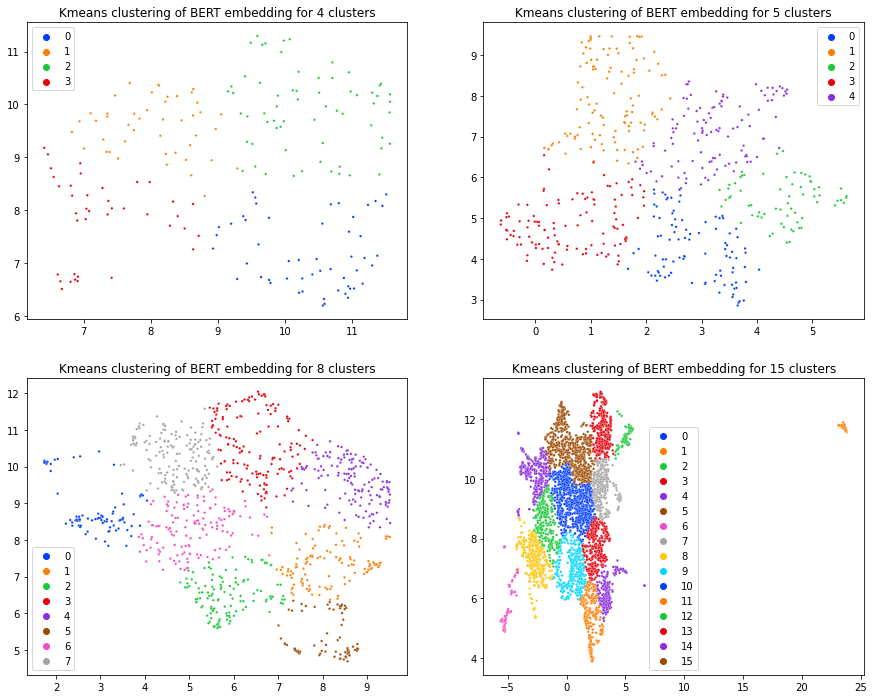

In [247]:
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.title('Kmeans clustering of BERT embedding for 4 clusters')
sns.scatterplot(umap_bert_DS1[:,0], umap_bert_DS1[:,1], s=6, hue=k_means_bert_ds1, palette='bright')
plt.subplot(222)
plt.title('Kmeans clustering of BERT embedding for 5 clusters')
sns.scatterplot(umap_bert_DS2[:,0], umap_bert_DS2[:,1], s=6, hue=k_means_bert_ds2, palette='bright')
plt.subplot(223)
plt.title('Kmeans clustering of BERT embedding for 8 clusters')
sns.scatterplot(umap_bert_DS3[:,0], umap_bert_DS3[:,1], s=6, hue=k_means_bert_ds3, palette='bright')
plt.subplot(224)
plt.title('Kmeans clustering of BERT embedding for 15 clusters')
sns.scatterplot(umap_bert_DS4[:,0], umap_bert_DS4[:,1], s=6, hue=k_means_bert_ds4, palette='bright')
plt.savefig('BERT clustering.pdf')

C:\Users\amg_m\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\amg_m\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\amg_m\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\amg_m\Anacond

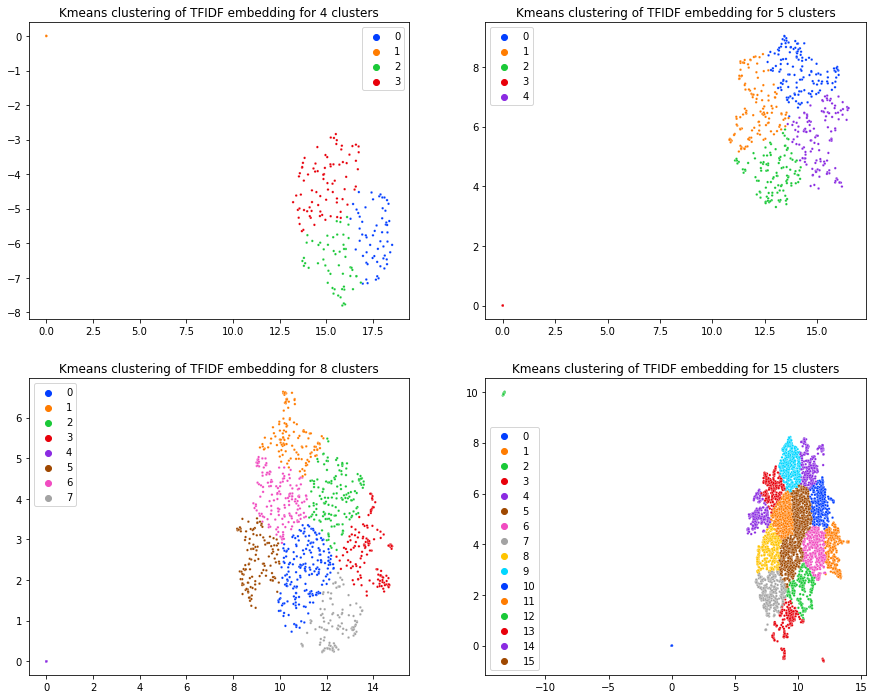

In [248]:
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.title('Kmeans clustering of TFIDF embedding for 4 clusters')
sns.scatterplot(umap_tfidf_DS1[:,0], umap_tfidf_DS1[:,1], s=6, hue=k_means_tfidf_ds1, palette='bright')
plt.subplot(222)
plt.title('Kmeans clustering of TFIDF embedding for 5 clusters')
sns.scatterplot(umap_tfidf_DS2[:,0], umap_tfidf_DS2[:,1], s=6, hue=k_means_tfidf_ds2, palette='bright')
plt.subplot(223)
plt.title('Kmeans clustering of TFIDF embedding for 8 clusters')
sns.scatterplot(umap_tfidf_DS3[:,0], umap_tfidf_DS3[:,1], s=6, hue=k_means_tfidf_ds3, palette='bright')
plt.subplot(224)
plt.title('Kmeans clustering of TFIDF embedding for 15 clusters')
sns.scatterplot(umap_tfidf_DS4[:,0], umap_tfidf_DS4[:,1], s=6, hue=k_means_tfidf_ds4, palette='bright')
plt.savefig('TFIDF clustering.pdf')

C:\Users\amg_m\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\amg_m\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\amg_m\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\amg_m\Anacond

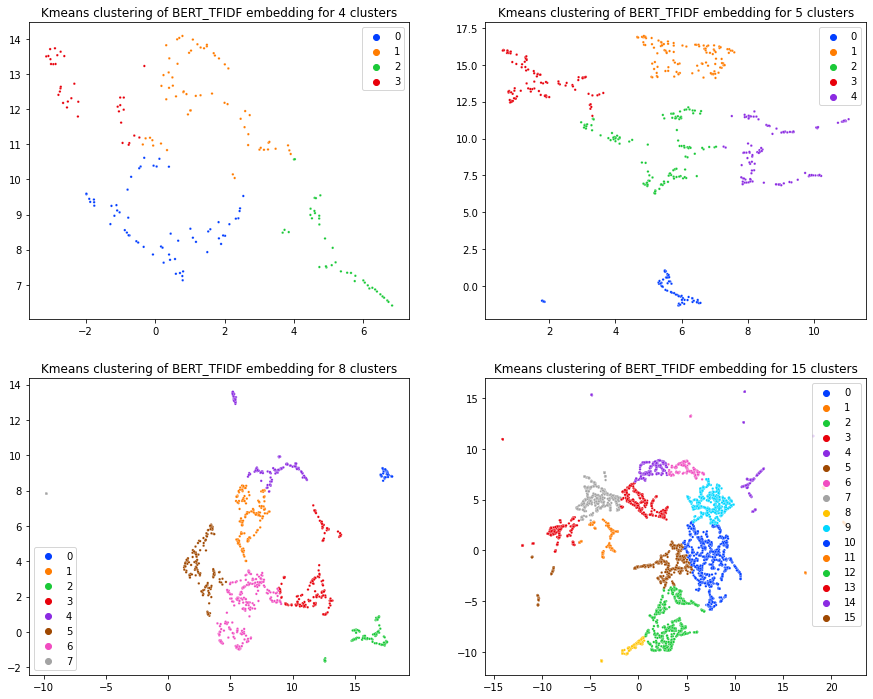

In [249]:
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.title('Kmeans clustering of BERT_TFIDF embedding for 4 clusters')
sns.scatterplot(umap_bert_tifid_DS1[:,0], umap_bert_tifid_DS1[:,1], s=6, hue=k_means_bert_tfidf_ds1, palette='bright')
plt.subplot(222)
plt.title('Kmeans clustering of BERT_TFIDF embedding for 5 clusters')
sns.scatterplot(umap_bert_tifid_DS2[:,0], umap_bert_tifid_DS2[:,1], s=6, hue=k_means_bert_tfidf_ds2, palette='bright')
plt.subplot(223)
plt.title('Kmeans clustering of BERT_TFIDF embedding for 8 clusters')
sns.scatterplot(umap_bert_tifid_DS3[:,0], umap_bert_tifid_DS3[:,1], s=6, hue=k_means_bert_tfidf_ds3, palette='bright')
plt.subplot(224)
plt.title('Kmeans clustering of BERT_TFIDF embedding for 15 clusters')
sns.scatterplot(umap_bert_tifid_DS4[:,0], umap_bert_tifid_DS4[:,1], s=6, hue=k_means_bert_tfidf_ds4, palette='bright')
plt.savefig('BERT_TFIDF clustering.pdf')

In [250]:
# Clusters are stored into a column in the respective dataframes, which will be used to compute metrics

In [251]:
reuters_DS1['bert_cluster']=0
reuters_DS1['tfidf_cluster']=0
reuters_DS1['bert_tfidf_cluster']=0
reuters_DS1['bert_cluster']= k_means_bert_ds1
reuters_DS1['tfidf_cluster']=k_means_tfidf_ds1
reuters_DS1['bert_tfidf_cluster']=k_means_bert_tfidf_ds1
reuters_DS1['y_hat']=0
###################################
reuters_DS2['bert_cluster']=0
reuters_DS2['tfidf_cluster']=0
reuters_DS2['bert_tfidf_cluster']=0
reuters_DS2['bert_cluster']= k_means_bert_ds2
reuters_DS2['tfidf_cluster']=k_means_tfidf_ds2
reuters_DS2['bert_tfidf_cluster']=k_means_bert_tfidf_ds2
reuters_DS2['y_hat']=0
##################################
reuters_DS3['bert_cluster']=0
reuters_DS3['tfidf_cluster']=0
reuters_DS3['bert_tfidf_cluster']=0
reuters_DS3['bert_cluster']= k_means_bert_ds3
reuters_DS3['tfidf_cluster']=k_means_tfidf_ds3
reuters_DS3['bert_tfidf_cluster']=k_means_bert_tfidf_ds3
reuters_DS3['y_hat']=0
##################################
reuters_DS4['bert_cluster']=0
reuters_DS4['tfidf_cluster']=0
reuters_DS4['bert_tfidf_cluster']=0
reuters_DS4['bert_cluster']= k_means_bert_ds4
reuters_DS4['tfidf_cluster']=k_means_tfidf_ds4
reuters_DS4['bert_tfidf_cluster']=k_means_bert_tfidf_ds4
reuters_DS4['y_hat']=0

In [252]:
# Function to compute cluster purity with plotting

def compute_plot_cluster_purity(df, cluster, label):
    
    grouped_cluster=df.groupby([cluster, label])[label].agg({'count'}).sort_values(by=[cluster, 'count'], ascending=False).reset_index()
    denominator=grouped_cluster['count'].sum()
    enumerator=0
    for i in range(len(df.category.unique())):  
        if grouped_cluster[grouped_cluster[cluster]==i]['count'].max()>0:
            enumerator+=grouped_cluster[grouped_cluster[cluster]==i]['count'].max()
    cluster_purity=enumerator/denominator
    
    fig, ax = plt.subplots(figsize=(25,10))
    sns.barplot(x=cluster, y='count', data=grouped_cluster, hue='category')
    plt.title(str(cluster)+'| Purity:'+str(cluster_purity), fontsize=18)
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')
    plt.savefig('DS1 4 clusters purity.pdf')
    plt.show()
    return cluster_purity

In [253]:
# Function to compute cluster purity

def compute_cluster_purity(df, cluster, label):
    
    grouped_cluster=df.groupby([cluster, label])[label].agg({'count'}).sort_values(by=[cluster, 'count'], ascending=False).reset_index()
    denominator=grouped_cluster['count'].sum()
    enumerator=0
    for i in range(len(df.category.unique())):  
        if grouped_cluster[grouped_cluster[cluster]==i]['count'].max()>0:
            enumerator+=grouped_cluster[grouped_cluster[cluster]==i]['count'].max()
    cluster_purity=enumerator/denominator
    
    
    return cluster_purity

In [254]:
reuters_DS1

,document,category,bert_cluster,tfidf_cluster,bert_tfidf_cluster,y_hat
0,president reagan ha said would veto legislatio...,trade,3,3,0,0
1,private analyst said financing large u . . bud...,money-fx,1,2,3,0
2,u . . treasury ' baker say currency within ran...,money-fx,1,2,3,0
3,"still presume take place second half march .""",acq,3,2,3,0
4,six major industrial country agreed meeting pa...,money-fx,1,2,3,0
...,...,...,...,...,...,...
195,coloroll agrees buy u . . wallcoverings compan...,acq,0,0,2,0
196,would also used ass progress policy goal .,trade,1,3,0,0
197,""" sanction provided useful excuse - achieving .",trade,3,3,0,0
198,"baker emphasized indicator device "" moving bey...",money-fx,3,2,3,0


In [255]:
# Utility function to extract truth labels for calculation of F1_score

def set_yhat_labels(df, cluster_type, y_hat):
    for i in range(len(df[cluster_type].value_counts())):
        y_hat_val= df[df[cluster_type]==i].category.value_counts().keys()[0]
        df.loc[df[cluster_type]==i, y_hat]= y_hat_val
    return df

In [256]:
def get_f1_score(df, cluster_type, y_hat):
    df=set_yhat_labels(df, cluster_type, y_hat)
    score=f1_score(df.category, df[y_hat], average='weighted')
    return score 

In [257]:
get_f1_score(reuters_DS1, 'bert_tfidf_cluster', 'y_hat')

0.4623214538883461

In [258]:
get_f1_score(reuters_DS1, 'tfidf_cluster', 'y_hat')

0.41043771043771043

In [259]:
get_f1_score(reuters_DS1, 'bert_cluster', 'y_hat')

0.35096575943810365

In [260]:
# Below code is to generate Dataframes containing the performance metrics

In [261]:
clusters=['bert_tfidf_cluster', 'tfidf_cluster', 'bert_cluster']

In [262]:
DS1_f1=[get_f1_score(reuters_DS1, cluster, 'y_hat') for cluster in clusters]
DS2_f1=[get_f1_score(reuters_DS2, cluster, 'y_hat') for cluster in clusters]
DS3_f1=[get_f1_score(reuters_DS3, cluster, 'y_hat') for cluster in clusters]
DS4_f1=[get_f1_score(reuters_DS4, cluster, 'y_hat') for cluster in clusters]

In [263]:
DS1_purity=[compute_cluster_purity(reuters_DS1, cluster, 'category') for cluster in clusters]
DS2_purity=[compute_cluster_purity(reuters_DS2, cluster, 'category') for cluster in clusters]
DS3_purity=[compute_cluster_purity(reuters_DS3, cluster, 'category') for cluster in clusters]
DS4_purity=[compute_cluster_purity(reuters_DS4, cluster, 'category') for cluster in clusters]

## Below are the performance metrics for each of the subsets
### DS1: 4 categories | DS2: 5 categories | DS3: 8 categories | DS4: 16 categories

In [264]:
pd.DataFrame(data=(DS1_f1, DS1_purity), columns=clusters, index=['F1_score', 'Purity'])

,bert_tfidf_cluster,tfidf_cluster,bert_cluster
F1_score,0.462321,0.410438,0.350966
Purity,0.460000,0.475000,0.405000


In [265]:
pd.DataFrame(data=(DS2_f1, DS2_purity), columns=clusters, index=['F1_score', 'Purity'])

,bert_tfidf_cluster,tfidf_cluster,bert_cluster
F1_score,0.495931,0.406848,0.51578
Purity,0.492000,0.458000,0.51400


In [266]:
pd.DataFrame(data=(DS3_f1, DS3_purity), columns=clusters, index=['F1_score', 'Purity'])

,bert_tfidf_cluster,tfidf_cluster,bert_cluster
F1_score,0.31055,0.387925,0.358063
Purity,0.36600,0.410000,0.380000


In [267]:
pd.DataFrame(data=(DS4_f1, DS4_purity), columns=clusters, index=['F1_score', 'Purity'])

,bert_tfidf_cluster,tfidf_cluster,bert_cluster
F1_score,0.248399,0.233030,0.211888
Purity,0.270896,0.274067,0.256530


### Below functions are displaying purity charts for a few of our models

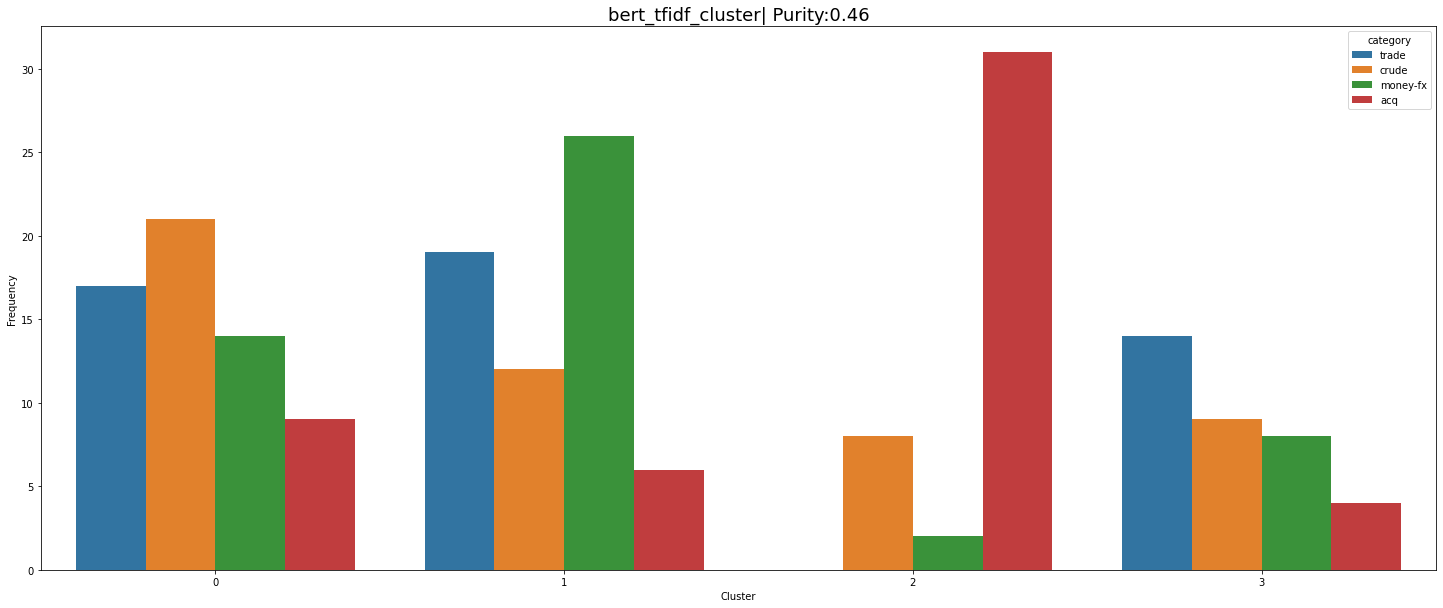

0.46

In [272]:
compute_plot_cluster_purity(reuters_DS1, 'bert_tfidf_cluster', 'category')

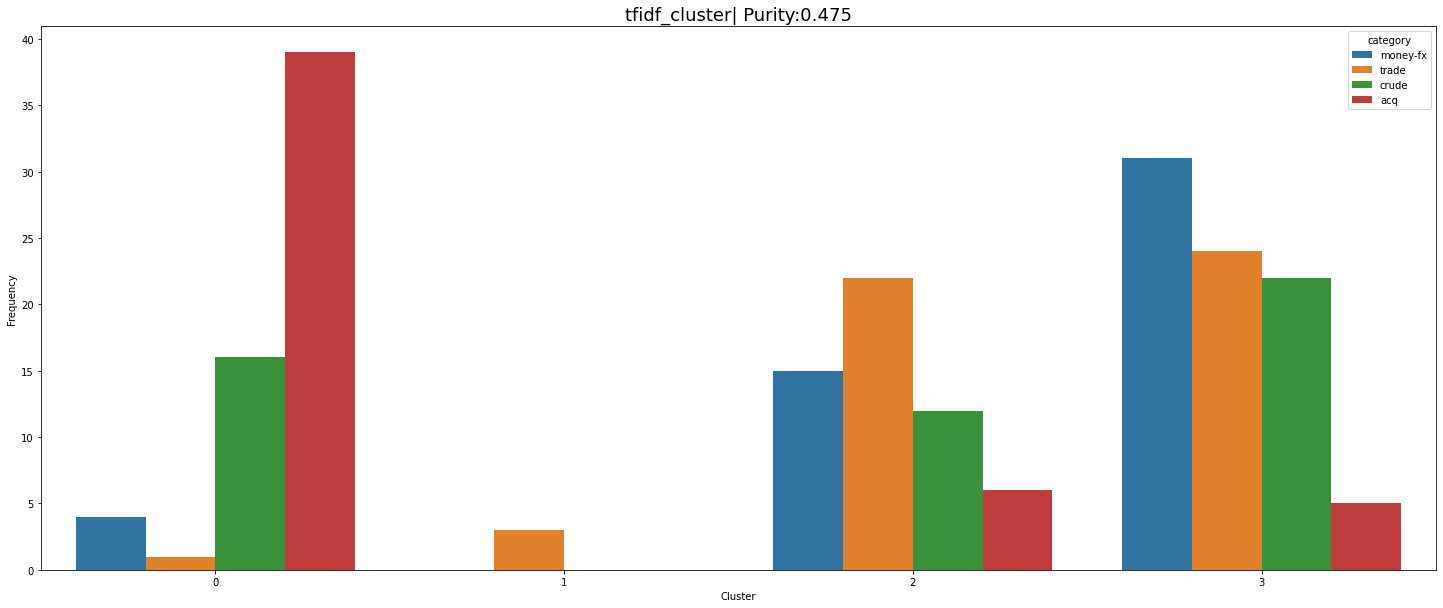

0.475

In [273]:
compute_plot_cluster_purity(reuters_DS1, 'tfidf_cluster', 'category')

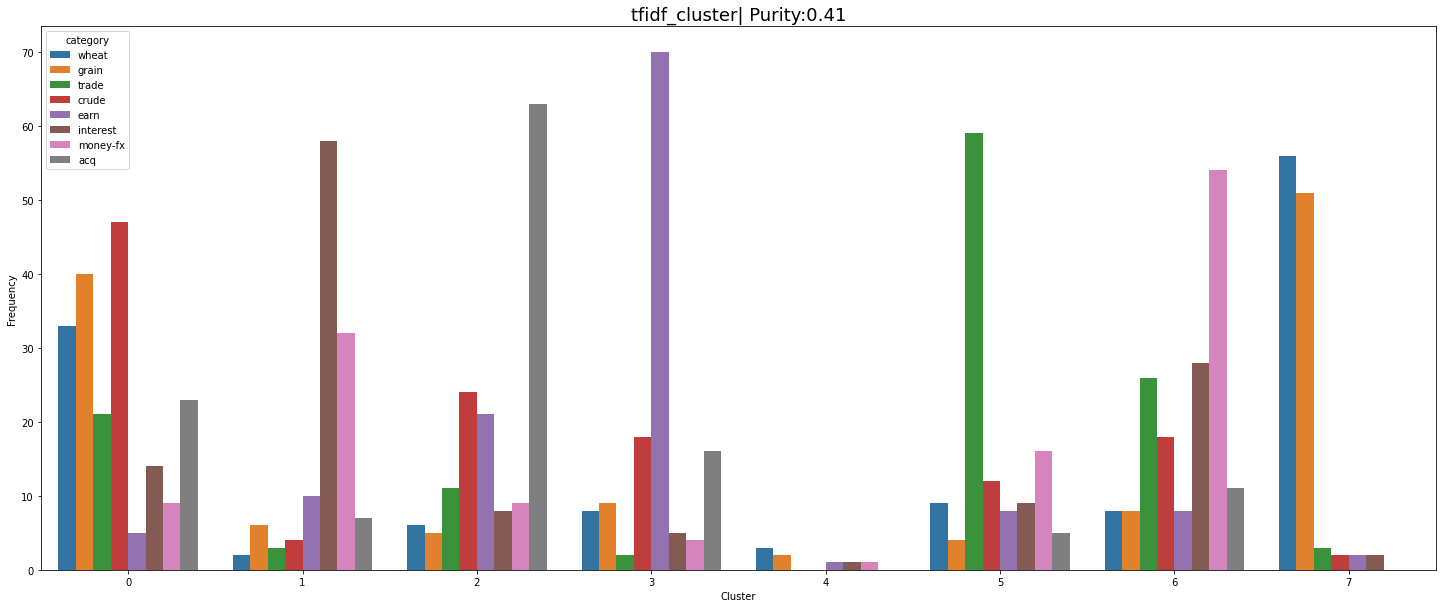

0.41

In [269]:
compute_plot_cluster_purity(reuters_DS3, 'tfidf_cluster', 'category')

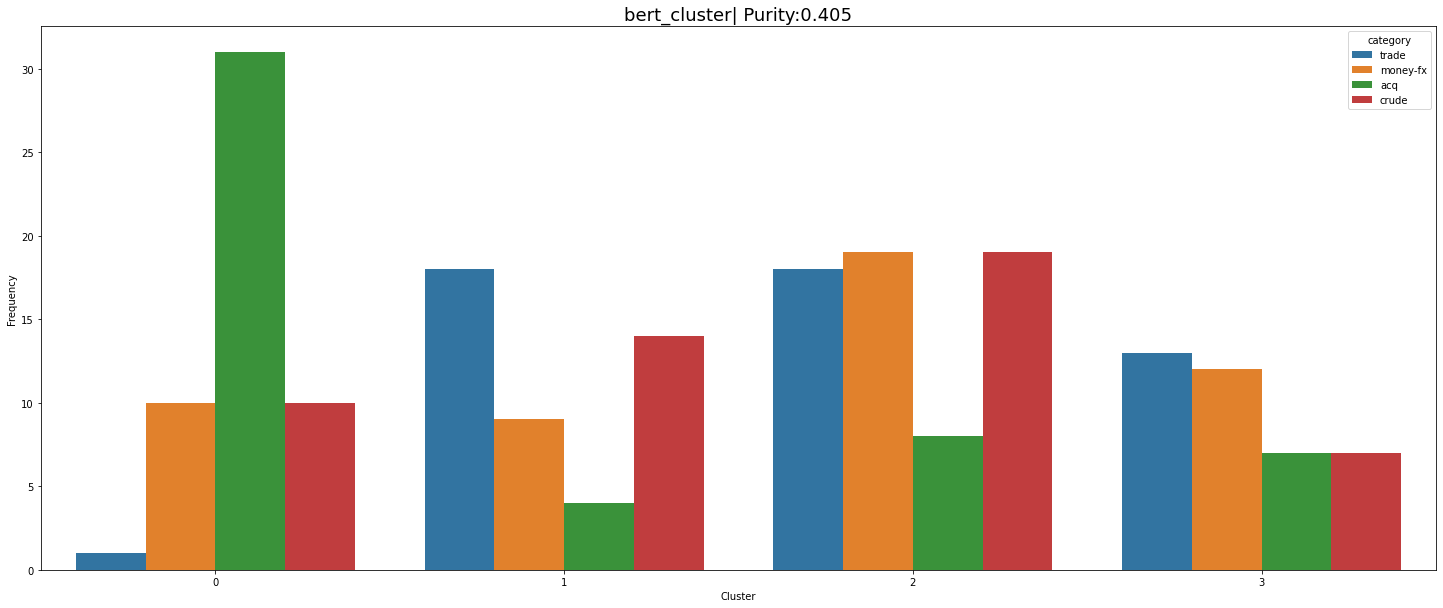

0.405

In [270]:
compute_plot_cluster_purity(reuters_DS1, 'bert_cluster', 'category')

# Conclusion and Future Direction

Text clustering is developing at an exciting phase, and the emergence of Transformers has not only revolutionalized supervised learning methods, but also tapped into unsupervised methods such as text clustering and topic modeling. By implementing this paper and reading many other related papers, I learned that different variants of BERT, particularely pre-trained models have a tremendous potential for improved text clustering tasks. Nonetheless, the dataset on which this paper was tested, Reuters-21578 has a very challenging set of documents for any model. Many of the underlying topics are extremely similar to each other, making it very challenging even for state-of-the-art embeddings such as BERT to make good sense in distinguishing between topics. Nonetheless, this means there is plenty of rooms for improvement in future research. I would take this further and try to add a step of fine-tuning BERT on the existing dataset, finding more optimal hyper-parameters for dimensonality reduction and finally trialing various clustering techniques that work well on high dimensional data. 

This being said, we should not discard the potential of older embeddings such as TF-IDF, GloVE, Word2Vec as their potential combined with BERT - as done in the implementation - proves to outperform each standalone approach.

# References:

[1]:  Yutong Li1 , Juanjuan Cai2 , Jingling Wang | A Text Document Clustering Method Based on
Weighted BERT Model

[2]:  Zuhua Dai et al 2020 J. Phys.: Conf. Ser. 1650 032090 | An Unsupervised Learning Short Text Clustering Method

[3]:  Shaohan Huang, Furu Wei, Lei Cui, Xingxing Zhang, Ming Zhou | Unsupervised Fine-tuning for Text Clustering

[4]:  Haoxiang Shi,  Cen Wang | Self-supervised Document Clustering Based on BERT with Data Augment